# ANN with BERT
In this notebook we tried to solve the classification model with an ANN based on pretrained BERT layers.

This notebook shows the training of the final model.

In [1]:
try:
    from google.colab import drive
    drive.mount('/content/drive/')
    %cd '/content/drive/MyDrive/'

    gpu_info = !nvidia-smi
    gpu_info = '\n'.join(gpu_info)
    if gpu_info.find('failed') >= 0:
      print('Not connected to a GPU')
    else:
      print(gpu_info)
except ImportError as e:
    pass

Mounted at /content/drive/
/content/drive/MyDrive
Sun May 29 15:22:37 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P0    28W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                      

In [2]:
!pip install tensorflow_text
!pip install tensorflow_hub
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.6 MB 8.8 MB/s 
     |████████████████████████████████| 511.7 MB 5.8 kB/s 
     |████████████████████████████████| 438 kB 71.5 MB/s 
     |████████████████████████████████| 5.8 MB 61.5 MB/s 
     |████████████████████████████████| 1.6 MB 46.9 MB/s 
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.8.0
    Uninstalling tensorflow-estimator-2.8.0:
      Successfully uninstalled tensorflow-estimator-2.8.0
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.8.0
    Uninstalling tensorboard-2.8.0:
      Successfully uninstalled tensorboard-2.8.0
  Attempting uninstall: keras
    Found existing installation: keras 2.8.0
    Uninstalling keras-2.8.0:
      Successfully uninstalled keras-2.8.0
  Attempting uninstall: gast
    Found existing installation: gast 0.5.3
    Uninst

In [3]:
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
import pandas as pd
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf
from sklearn.model_selection import StratifiedKFold
from keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
from matplotlib import pyplot as plt
import seaborn as sn
from sklearn.model_selection import train_test_split

In [17]:
df = pd.read_csv('/content/drive/MyDrive/Data Mining/dataset.txt')
df.describe()

,text,humor
count,200000,200000
unique,200000,2
top,"Joe biden rules out 2020 bid: 'guys, i'm not r...",False
freq,1,100000


# Preprocess data

In [18]:
# Transform class from Boolean to integer value
df['class']=df['humor'].apply(lambda x: 1 if x==True else 0)

In [19]:
from transformers import BertTokenizer
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

MAX_LEN = 128
#pad_to_max_length=True,
df['bert_preprocessed']=df['text'].apply(lambda x: " ".join(list(tokenizer.convert_ids_to_tokens(tokenizer.encode(x, add_special_tokens=True, max_length=MAX_LEN, truncation=True)))))

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [20]:
df.head()

,text,humor,class,bert_preprocessed
0,"Joe biden rules out 2020 bid: 'guys, i'm not r...",False,0,[CLS] joe bid ##en rules out 2020 bid : ' guys...
1,Watch: darvish gave hitter whiplash with slow ...,False,0,[CLS] watch : dar ##vish gave hitter whip ##la...
2,What do you call a turtle without its shell? d...,True,1,[CLS] what do you call a turtle without its sh...
3,5 reasons the 2016 election feels so personal,False,0,[CLS] 5 reasons the 2016 election feels so per...
4,"Pasco police shot mexican migrant from behind,...",False,0,[CLS] pas ##co police shot mexican migrant fro...


In [21]:
X = df['bert_preprocessed']
Y = df['class']

In [7]:
bert_preprocess = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3")
bert_encoder = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4")

# Keras model

In [5]:
def build_model() -> tf.keras.Model:
    # Bert layers
    text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
    preprocessed_text = bert_preprocess(text_input)
    outputs = bert_encoder(preprocessed_text)

    # Neural network layers
    l = tf.keras.layers.Dropout(0.1, name="dropout")(outputs['pooled_output'])
    l = tf.keras.layers.Dense(1, activation='sigmoid', name="output")(l)

    # Use inputs and outputs to construct a final model
    model = tf.keras.Model(inputs=[text_input], outputs = [l])

    #model.summary()

    return model

# Train model

Here we train the model with the identified adam learning rate, adam epsilon and the batch size. 

To ensure reaching the maximum accuracy we used the EarlyStopping class from keras. This class allows the training to run until a maximum of 50 epochs but will be stopped, as soon as the loss does not decrease for two epochs.

Besides EarlyStopping we also used a k-4 fold to make sure every row is once in the training and once in the test set. 

In [26]:
def own_test(model):
  jokes = [
      'What’s the best thing about Switzerland? I don’t know, but the flag is a big plus.',
      'I study Business Informatics at the University of Mannheim!',
      'I invented a new word! Plagiarism!',
      'Did you hear about the mathematician who’s afraid of negative numbers? He’ll stop at nothing to avoid them.',
      'My name is Elias.'
  ]

  jokes_processed = [" ".join(list(tokenizer.convert_ids_to_tokens(tokenizer.encode(i, add_special_tokens=True, max_length=MAX_LEN, truncation=True)))) for i in jokes]

  print(model.predict(jokes_processed))

In [ ]:
def train_evaluate(model, run, x_train, y_train, x_test, y_test):
      base_path = "/content/drive/MyDrive/Data Mining/bert_uncased/"

      ADAM_LEARNING_RATE = 0.004
      ADAM_EPSILON = 1e-05

      EPOCH = 50

      BATCH_SIZE = 64

      PATIENCE = 2

      METRICS = [
            tf.keras.metrics.BinaryAccuracy(name='accuracy'),
            tf.keras.metrics.Precision(name='precision'),
            tf.keras.metrics.Recall(name='recall'),
      ]

      STAMP = 'model_run_%.2f'%(run)
      early_stopping = EarlyStopping(monitor='val_loss', patience=PATIENCE)
      bst_model_path = base_path + STAMP + '.h5'
      model_checkpoint = ModelCheckpoint(bst_model_path, save_best_only=True, save_weights_only=True)

      model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=ADAM_LEARNING_RATE, epsilon=ADAM_EPSILON),
                  loss=tf.keras.losses.BinaryCrossentropy(),                  
                  metrics=METRICS)


      X_tra, X_val, y_tra, y_val = train_test_split(x_train, y_train, test_size=0.2)

      hist = model.fit(X_tra, y_tra, validation_data=(X_val, y_val), epochs=EPOCH, batch_size=BATCH_SIZE, shuffle=True, callbacks=[early_stopping, model_checkpoint])

      y_predicted = model.predict(x_test)
      y_predicted = y_predicted.flatten()

      y_predicted = np.where(y_predicted > 0.5, 1, 0)

      cm = confusion_matrix(y_test, y_predicted)

      sn.heatmap(cm, annot=True, fmt='d')
      plt.xlabel('Predicted')
      plt.ylabel('Truth')
      plt.show()
      print(classification_report(y_test, y_predicted))

      own_test(model)
      return model.evaluate(x_test, y_test)

# Cross validation
Since training takes about 4-5 hours per fold, cross validation could not be implemented. But a working code example can be seen below:

```python
kFold = StratifiedKFold(n_splits=4)
accuracy_list = []
precision_list = []
recall_list = []
i = 1
for train, test in kFold.split(X, Y):
    model = build_model()
    _, accuracy, precision, recall = train_evaluate(model, i, X[train], Y[train], X[test], Y[test])
    accuracy_list.append(accuracy)
    precision_list.append(precision)
    recall_list.append(recall)
    i = i + 1

print(accuracy_list)
print(precision_list)
print(recall_list)

print(f"Accuracy: {sum(accuracy_list) / len(accuracy_list)}")
print(f"Precision: {sum(precision_list) / len(precision_list)}")
print(f"Recall: {sum(recall_list) / len(recall_list)}")
```


Epoch 1/50
1875/1875 [==============================] - 1068s 568ms/step - loss: 0.2882 - accuracy: 0.8829 - precision: 0.8752 - recall: 0.8935 - val_loss: 0.2370 - val_accuracy: 0.9040 - val_precision: 0.8606 - val_recall: 0.9631
Epoch 2/50
1875/1875 [==============================] - 1062s 567ms/step - loss: 0.2412 - accuracy: 0.9035 - precision: 0.8988 - recall: 0.9096 - val_loss: 0.2051 - val_accuracy: 0.9199 - val_precision: 0.8913 - val_recall: 0.9556
Epoch 3/50
1875/1875 [==============================] - 1060s 566ms/step - loss: 0.2355 - accuracy: 0.9064 - precision: 0.9033 - recall: 0.9105 - val_loss: 0.2089 - val_accuracy: 0.9184 - val_precision: 0.9534 - val_recall: 0.8791
Epoch 4/50
1875/1875 [==============================] - 1055s 562ms/step - loss: 0.2340 - accuracy: 0.9072 - precision: 0.9043 - recall: 0.9110 - val_loss: 0.1873 - val_accuracy: 0.9270 - val_precision: 0.9124 - val_recall: 0.9440
Epoch 5/50
1875/1875 [==============================] - 1060s 566ms/step - l

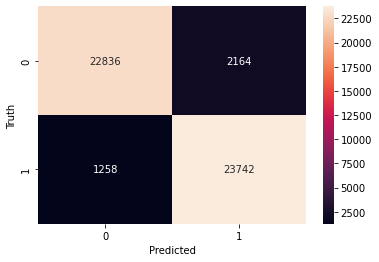

              precision    recall  f1-score   support

           0       0.95      0.91      0.93     25000
           1       0.92      0.95      0.93     25000

    accuracy                           0.93     50000
   macro avg       0.93      0.93      0.93     50000
weighted avg       0.93      0.93      0.93     50000

1/1 [==============================] - 1s 670ms/step
[[0.9875167]
 [0.6525986]
 [0.8481076]
 [0.9897831]
 [0.982907 ]]
1563/1563 [==============================] - 328s 210ms/step - loss: 0.1821 - accuracy: 0.9316 - precision: 0.9165 - recall: 0.9497


In [ ]:
# Create train test split for training
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.4)

model = build_model()
_, accuracy, precision, recall = train_evaluate(model, 0, X_train, y_train, X_test, y_test)

\* due to the long running training phase and different iterations of optimization the output is not fully available

# Evaluate trained model
The training took around 3-4 hours. The mode can be downloaded from google drive:

- https://drive.google.com/file/d/1kyNhwrM-pBY81motyOOqdDCQ2kxpqv_j/view?usp=sharing

The model scored an accuracy of 0.9316.